This notebook is based on https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/notebooks/art_evaluations/security_curve.ipynb

ART includes evaluation module for generating Security Curves. Security Curves help to determine and compare the robustness of machine learning models against adversarial examples, as well as to determine abscence of defense which can be exploited by an adaptive adversary

+ [1] A. Madry et al.: Towards Machine Learning Models Resistant to Adversarial Attacks. https://arxiv.org/abs/1706.06083
+ [2] Y. Dong et al.: Benchmarking Adversarial Robustness on Image Classification. https://arxiv.org/abs/1912.11852
+ [3] N. Carlini et al.: On Evaluating Adversarial Robustness. https://arxiv.org/abs/1902.06705

In [2]:
import torch
from keras.models import load_model

from robustness.datasets import CIFAR
from robustness.model_utils import make_and_restore_model

import numpy as np

from art.config import ART_DATA_PATH
from art.utils import load_dataset, get_file
from art.evaluations.security_curve import SecurityCurve

from art.estimators.classification import PyTorchClassifier, KerasClassifier

In [2]:
# Load CIFAR-10 dataset
(x_train_cifar, y_train_cifar), (x_test_cifar, y_test_cifar), min_cifar, max_cifar = load_dataset("cifar10")

In [3]:
# Change format frm NHWC to NCHW for PyTorch
x_train_cifar = np.transpose(x_train_cifar, (0, 3, 1, 2)).astype(np.float32)
x_test_cifar = np.transpose(x_test_cifar, (0, 3, 1, 2)).astype(np.float32)

In [4]:
# Define argument for PGD attack used in evaluation, except `classifier` and `eps`
kwargs_pgd = {"norm": "inf",
              "eps_step": 1/255,
              "max_iter": 100,
              "targeted": False,
              "num_random_init": 0,
              "batch_size": 128,
              "random_eps": False,
              "verbose": False,
             }

In [5]:
# Define attack budgets for evaluation as a list of floats
eps = [i / 255 for i in range(1, 32, 2)]

In [6]:
# Create an instance of a Security Curve evaluation
sc = SecurityCurve(eps=eps)

In [7]:
# Load a robust PyTorch model using the package `robustness` (https://github.com/MadryLab/robustness)
path_to_cifar10_data = "tmp/data/"
resume_path = "tmp/cifar_linf_8.pt"

ds = CIFAR(path_to_cifar10_data)
m, _ = make_and_restore_model(arch='resnet50',
                              dataset=ds,
                              resume_path=resume_path,
                             )

=> loading checkpoint 'tmp/cifar_linf_8.pt'
=> loaded checkpoint 'tmp/cifar_linf_8.pt' (epoch 153)


In [8]:
# Define mean and standard-deviation for preprocessing of the PyTorch model
mean=np.asarray([0.4914, 0.4822, 0.4465]).reshape(3, 1, 1).astype(np.float32)
std=np.asarray([0.2023,  0.1994, 0.2010]).reshape(3, 1, 1).astype(np.float32)

In [9]:
# Create an ART estimator for the PyTorch classification model
robust_classifier_cifar = PyTorchClassifier(model=m.model, 
                                            clip_values=(min_cifar, max_cifar),
                                            loss=torch.nn.CrossEntropyLoss(),
                                            input_shape=(3, 32, 32),
                                            nb_classes=10,
                                            preprocessing=(mean, std))

In [10]:
# Evaluate Security Curve for robust PyTorch classifier on CIFAR-10 on the first 100 samples
eps_list, accuracy_adv_list, accuracy = sc.evaluate(classifier=robust_classifier_cifar,
                                                    x=x_train_cifar[0:100],
                                                    y=y_train_cifar[0:100],
                                                    **kwargs_pgd)

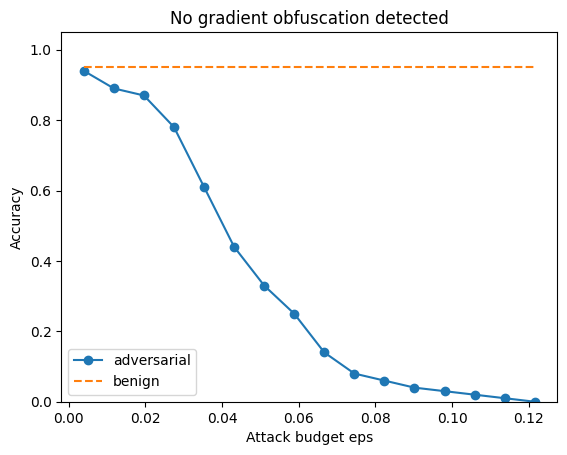

In [11]:
# Plot the Security Curve for the evaluation of the robust PyTorch classifier on CIFAR-10
sc.plot()

In [12]:
# Check if the robust PyTorch classifier is potentially obfuscating loss gradients
sc.detected_obfuscating_gradients

False

## Evaluating another robust model

In [16]:
import transformers

model = transformers.AutoModelForImageClassification.from_pretrained(
    'facebook/deit-tiny-distilled-patch16-224',
    ignore_mismatched_sizes=True,
    num_labels=10
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

(x_train, y_train), (_,_), _,_ = load_dataset("cifar10")

x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
y_train = np.argmax(y_train, axis=1)

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-tiny-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([10, 192]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([10, 192]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
from art.estimators.classification.hugging_face import HuggingFaceClassifierPyTorch
import torch

upsampler = torch.nn.Upsample(scale_factor=7, mode="nearest")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = torch.nn.CrossEntropyLoss()
hf_model = HuggingFaceClassifierPyTorch(
    model=model,
    loss=loss_fn,
    optimizer=optimizer,
    input_shape =(3,32,32),
    nb_classes=10,
    clip_values=(0,1),
    processor=upsampler
)

In [13]:
# load saved model if it already exists, otherwise train it
import os 
from art.defences.trainer import AdversarialTrainerMadryPGD

trainer = AdversarialTrainerMadryPGD(
    classifier=hf_model,
    nb_epochs=10,
    eps=8/255,
    eps_step=1/255,
    max_iter=10
)

model_checkpoint_path = './state_dicts/deit_cifar_robust_model.pt'
if os.path.isfile(model_checkpoint_path):
    trainer.classifier.model.load_state_dict(torch.load(model_checkpoint_path, map_location=device))
    print('loaded model checkpoint')
else:
    trainer.fit(x_subset, y_subset, nb_epochs=5)
    torch.save(trainer.classifier.model.state_dict(), model_checkpoint_path)
    print('saved model checkpoint')

loaded model checkpoint


C:\Users\Usuario\AppData\Local\Temp\ipykernel_30328\93170867.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trainer.classifier.model.load_state_dict(torch.load(model_c

In [22]:
# Evaluate Security Curve for robust PyTorch classifier on CIFAR-10 on the first 100 samples
kwargs_pgd = {"norm": "inf",
              "eps_step": 1/255,
              "max_iter": 100,
              "targeted": False,
              "num_random_init": 0,
              "batch_size": 128,
              "random_eps": False,
              "verbose": False,
             }
# Define attack budgets for evaluation as a list of floats
# Load CIFAR-10 dataset
(x_train, y_train), (_,_), _,_ = load_dataset("cifar10")

x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
y_train = np.argmax(y_train, axis=1)

classes = np.unique(y_train)
samples_per_class = 100

x_subset=[]
y_subset=[]

for c in classes:
    indices = y_train == c
    x_subset.append(x_train[indices][:samples_per_class])
    y_subset.append(y_train[indices][:samples_per_class])

x_subset = np.concatenate(x_subset)
y_subset = np.concatenate(y_subset)

print(f'x_subset:', x_subset.dtype, x_subset.shape)
print(f'y_subset:', y_subset.dtype, y_subset.shape)

eps = [i / 255 for i in range(1, 32, 2)]
# Create an instance of a Security Curve evaluation
sc = SecurityCurve(eps=eps)
eps_list, accuracy_adv_list, accuracy = sc.evaluate(classifier=hf_model,
                                                    x=x_subset,
                                                    y=y_subset)

x_subset: float32 (1000, 3, 32, 32)
y_subset: int64 (1000,)


AxisError: axis 1 is out of bounds for array of dimension 1